In [1]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from pathlib import Path

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from spectral_metric.estimator import CumulativeGradientEstimator
from spectral_metric.visualize import make_graph

In [3]:
# Lectura de dataset

data_dir = ('CIFAR-10-only train')
data_dir = pathlib.Path(data_dir)

# Lectura de la carpeta train
data_dir_train = ('CIFAR-10-only train/train')
data_dir_train = pathlib.Path(data_dir_train)



image_count_train = len(list(data_dir_train.glob('*/*.png')))  # Cuenta la cantidad de imagenes de train


print(f"Cantidad de imagenes de train: {image_count_train}")

Cantidad de imagenes de train: 60000


In [4]:
# Dimensiones de imagen y tamaño de batch
img_height = 32
img_width = 32
#batch_size = len(list(data_dir.glob('*/*.png'))) # leer todas las imágenes al tiempo
batch_size = image_count_train

In [5]:
# PARA TRABAJAR CON LAS 20 CLASES, TOMAR LAS CARPETAS DE TEST Y LLEVARLAS A TRAIN (RENOMBRANDOLAS)

import tensorflow as tf
import pathlib

# Data splitting (entrenamiento y validación)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60000 files belonging to 20 classes.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)  # get the number of the classes
print(f"Número de clases: {num_classes}")
print(f"Los nombres de las clases son: {class_names}")

Número de clases: 20
Los nombres de las clases son: ['airplane', 'airplane_t', 'automobile', 'automobile_t', 'bird', 'bird_t', 'cat', 'cat_t', 'deer', 'deer_t', 'dog', 'dog_t', 'frog', 'frog_t', 'horse', 'horse_t', 'ship', 'ship_t', 'truck', 'truck_t']


In [7]:
for images, labels0 in train_ds.take(1):  # only take first element of dataset
    x_train = images.numpy()
    y_train = labels0.numpy()

x_train /= 255.0  # Scale the features to the [0, 1] range
#x_train = x_train.reshape(len(x_train), 1, 256, 256)  # reshape into [N, C, H, W] for PyTorch
print(x_train.shape)

(60000, 32, 32, 3)


c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\Desktop\Proyecto-CSG\1 - prueba de CSG\Pruebas en distintos datasets\spectral_metric\visualize.py:48: RuntimeWarning: divide by zero enco

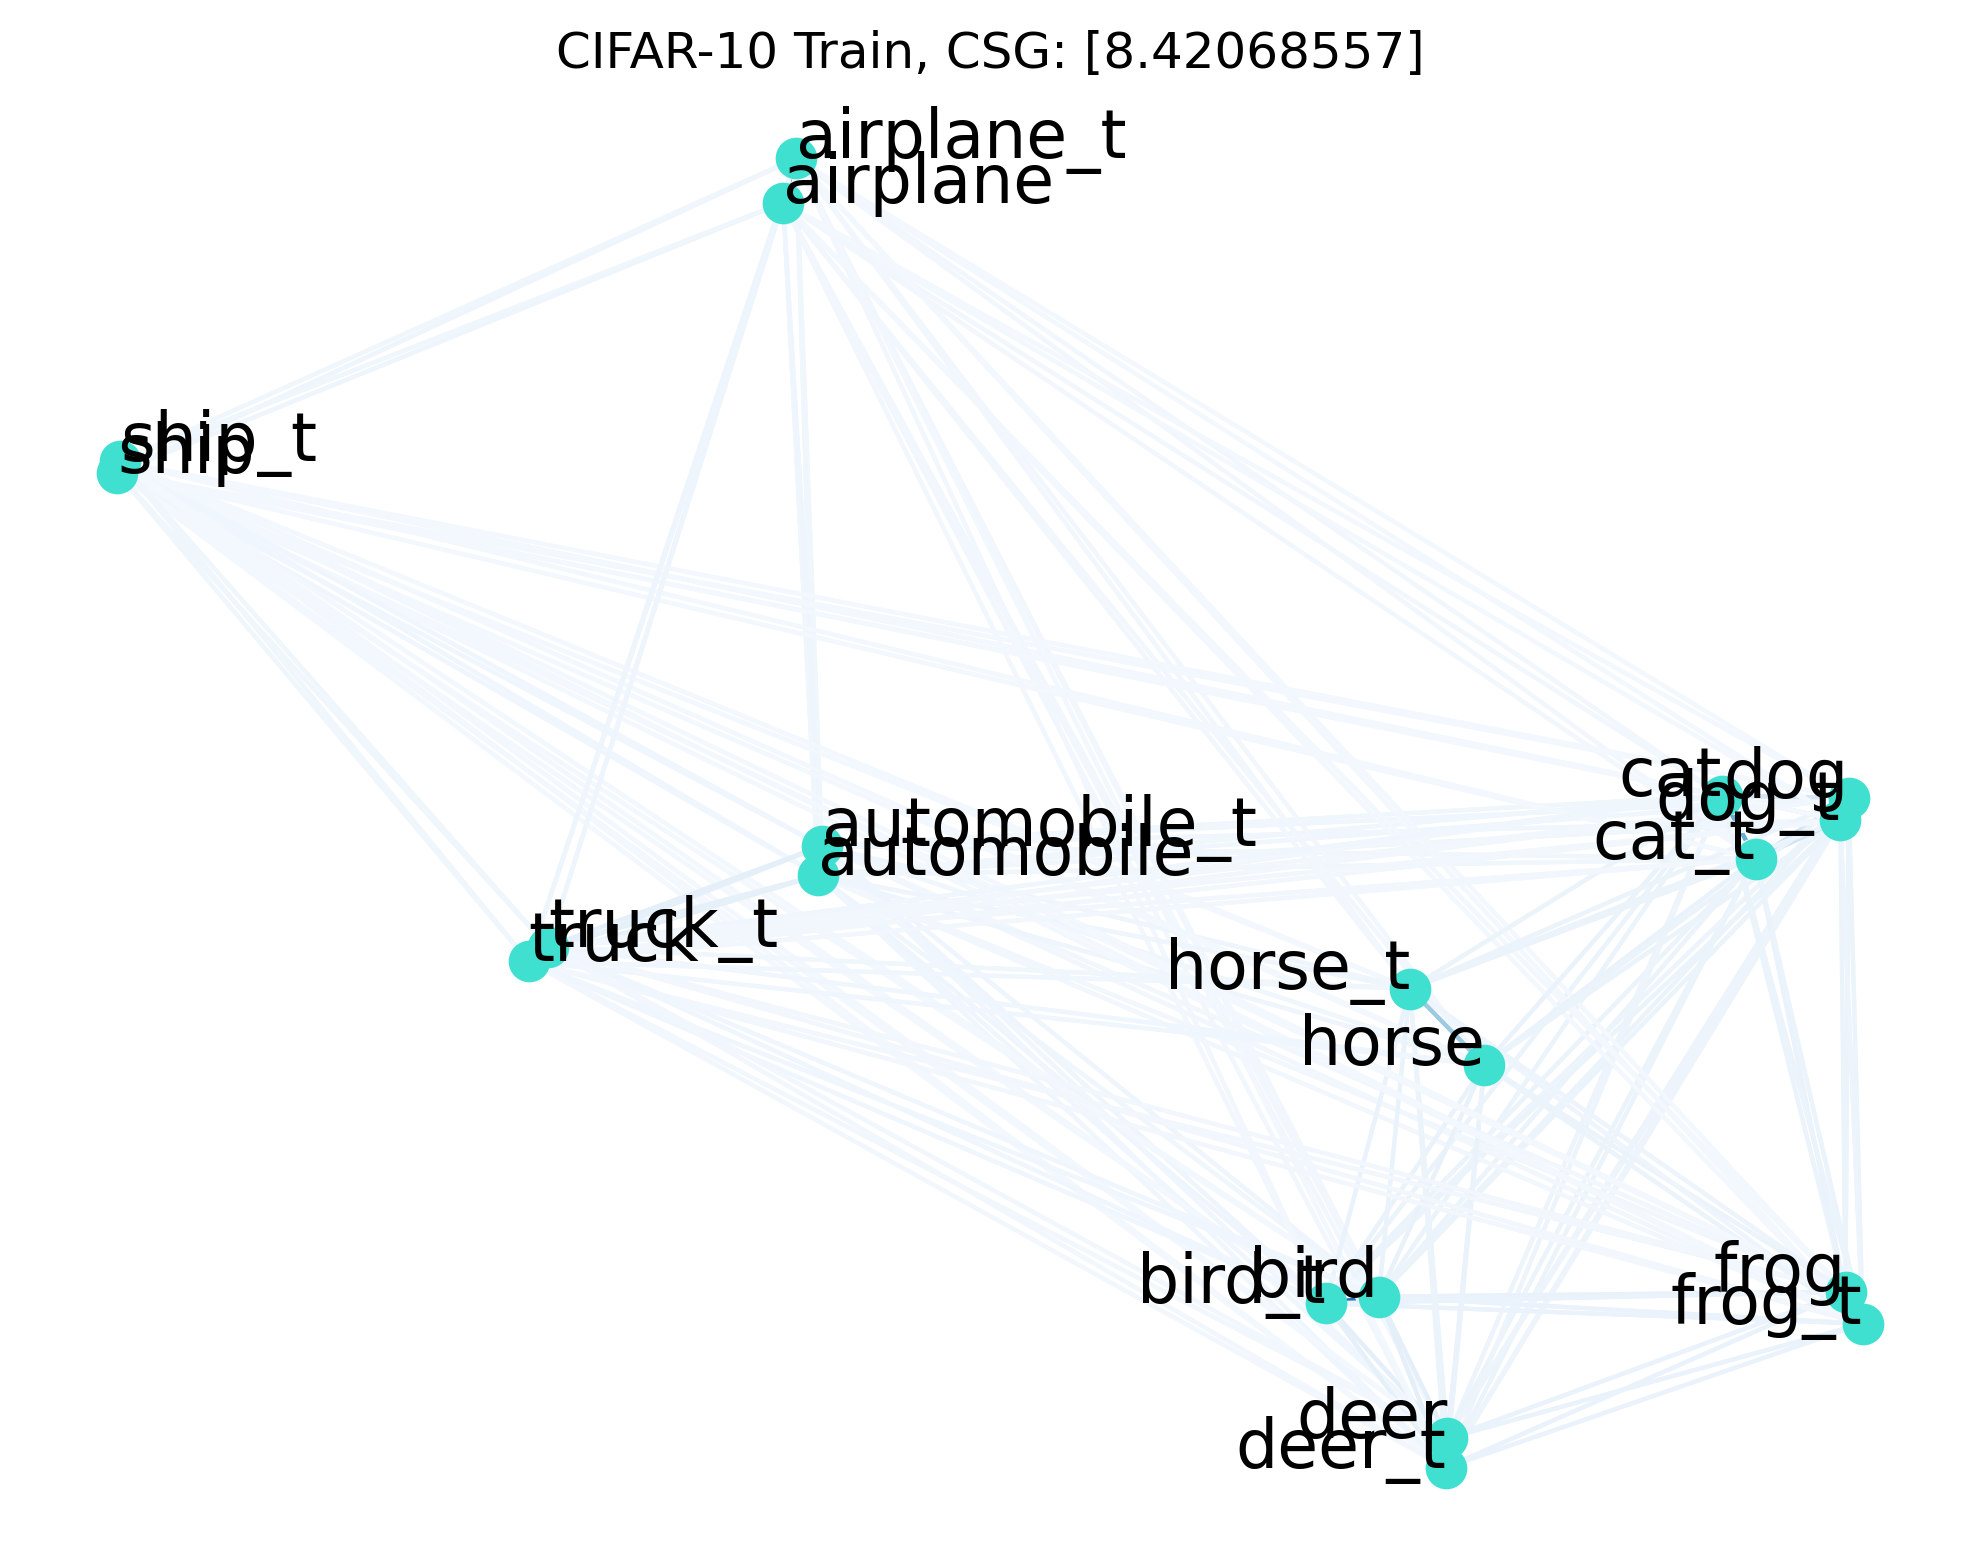

In [8]:
# CIFAR-10 TRAIN SET
X = x_train.reshape( (x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3]))
y = y_train.reshape(y_train.shape[0],)

estimator = CumulativeGradientEstimator(M_sample=1000, k_nearest=10)
estimator.fit(data=X, target=y)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

# Plot the dataset
#make_graph(estimator.difference, title="CIFAR-10 Train, CSG: "+str(csg), classes=["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

#make_graph(estimator.difference, title="CIFAR-10 Train, CSG: "+str(csg), classes=["airplane", "automobile", "bird",  "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

#make_graph(estimator.difference, title="CIFAR-10 Train, CSG: "+str(csg), classes=["airplane", "airplane_t", "automobile", "automobile_t", "bird", "bird_t",  "cat", "cat_t", "deer", "deer_t", "dog", "dog_t", "frog", "frog_t", "horse", "horse_t", "ship", "ship_t", "truck", "truck_t"])

make_graph(estimator.difference, title="CIFAR-10 Train, CSG: "+str(csg), classes=class_names)

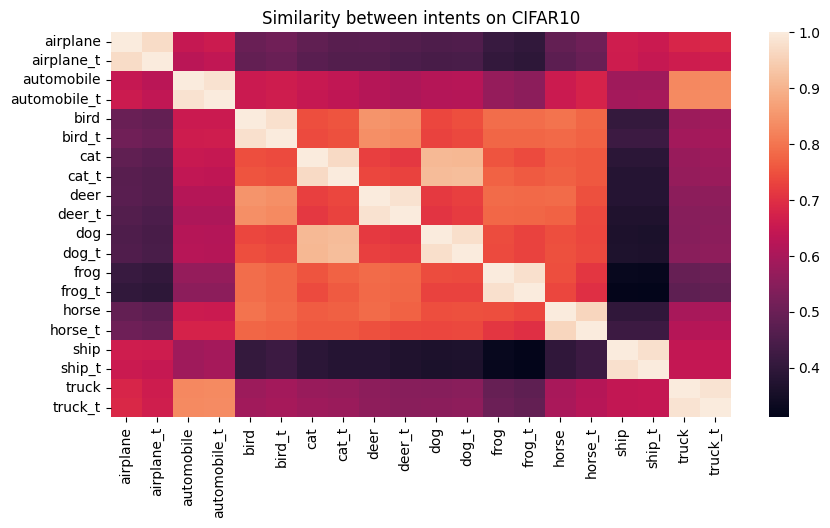

In [9]:
plt.figure(figsize=(10,5))
# Establecer las etiquetas del eje y con los nombres de las clases
sns.heatmap(estimator.W, xticklabels=class_names, yticklabels=class_names)
plt.title("Similarity between intents on CIFAR10")
plt.show()

In [52]:
#class_names=["airplane", "automobile", "bird",  "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
#class_names=["airplane", "airplane_t", "automobile", "automobile_t", "bird", "bird_t",  "cat", "cat_t", "deer", "deer_t", "dog", "dog_t", "frog", "frog_t", "horse", "horse_t", "ship", "ship_t", "truck", "truck_t"]

from scipy.stats import entropy
import pandas as pd
entropy_per_class = entropy(estimator.W / estimator.W.sum(-1)[:, None], axis=-1)  # Mide la incertidumbre o desorden de las clases
print("Class that is the most confused (highest entropy):", class_names[np.argmax(entropy_per_class)])  # Muestra cual es la clase que encuentra mas dificil de clasificar o la clase en la cual las predicciones para el modelo son mas imprecisas

Class that is the most confused (highest entropy): automobile_t


In [62]:
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))[::-1]
pairs = [(i, j) for i, j in pairs if i != j]
# Obtener el par más similar
most_similar_pair = pairs[0]
i, j = most_similar_pair  # Pares de clases más similares

In [80]:
"""
print("Most similar pairs")
lst = []
for idx, (i, j) in enumerate(pairs[::2][:10]):  # Mostramos los 10 pares más similares
    lst.append({"Intent pair": f"{class_names[i]} <> {class_names[j]}", "Similarity": estimator.W[i, j]})
print(pd.DataFrame(lst))
"""

Most similar pairs
                  Intent pair  Similarity
0            truck <> truck_t    0.985200
1  automobile <> automobile_t    0.982020
2              deer_t <> deer    0.981500
3              ship <> ship_t    0.980600
4              frog <> frog_t    0.979600
5              bird <> bird_t    0.979554
6                dog_t <> dog    0.976657
7      airplane <> airplane_t    0.970600
8                cat_t <> cat    0.970400
9            horse <> horse_t    0.960643


In [84]:

print("Most similar pairs")
lst = []
for idx, (i,j) in enumerate(pairs[::2][:10]):
    lst.append({"Intent pair" : f"{class_names[i]} <> {class_names[j]}", "Similarity": estimator.W[i,j]})
print(pd.DataFrame(lst))

Most similar pairs
                  Intent pair  Similarity
0            truck <> truck_t    0.985200
1  automobile <> automobile_t    0.982020
2              deer_t <> deer    0.981500
3              ship <> ship_t    0.980600
4              frog <> frog_t    0.979600
5              bird <> bird_t    0.979554
6                dog_t <> dog    0.976657
7      airplane <> airplane_t    0.970600
8                cat_t <> cat    0.970400
9            horse <> horse_t    0.960643


In [85]:
class_i_samples = X[y == i]
class_j_samples = X[y == j]

In [86]:
from scipy.spatial.distance import cdist

# Encontrar la muestra más similar de la clase i con la clase j y viceversa
dist_matrix_ij = cdist(class_i_samples, class_j_samples)
min_dist_idx_ij = np.unravel_index(np.argmin(dist_matrix_ij), dist_matrix_ij.shape)

# Muestra de la clase i más similar a las muestras de la clase j
most_similar_i_to_j = class_i_samples[min_dist_idx_ij[0]]
# Muestra de la clase j más similar a las muestras de la clase i
most_similar_j_to_i = class_j_samples[min_dist_idx_ij[1]]

In [87]:
# Obtener los nombres de archivo correspondientes
filenames = [f.name for f in data_dir_train.glob('*/*.png')]
class_i_indices = np.where(y == i)[0]
class_j_indices = np.where(y == j)[0]

most_similar_i_to_j_filename = filenames[class_i_indices[min_dist_idx_ij[0]]]
most_similar_j_to_i_filename = filenames[class_j_indices[min_dist_idx_ij[1]]]

In [88]:
# Calcular la distancia de similitud entre las muestras seleccionadas
similarity_value = np.linalg.norm(most_similar_i_to_j - most_similar_j_to_i)

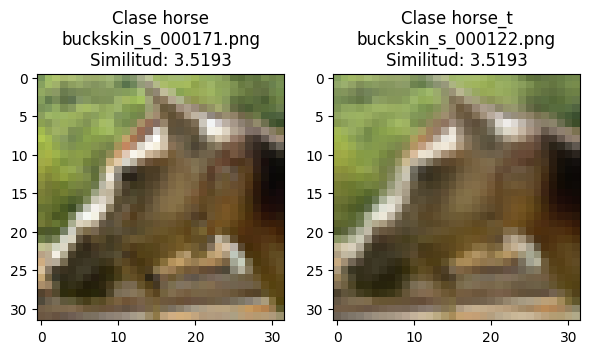

In [89]:
# Visualizar las muestras y la información
most_similar_i_to_j_img = most_similar_i_to_j.reshape(img_height, img_width, 3)
most_similar_j_to_i_img = most_similar_j_to_i.reshape(img_height, img_width, 3)

fig, axs = plt.subplots(1, 2, figsize=(7, 5))
axs[0].imshow(most_similar_i_to_j_img)
axs[0].set_title(f'Clase: {class_names[i]}\n{most_similar_i_to_j_filename}\nSimilitud: {similarity_value:.4f}')
axs[1].imshow(most_similar_j_to_i_img)
axs[1].set_title(f'Clase: {class_names[j]}\n{most_similar_j_to_i_filename}\nSimilitud: {similarity_value:.4f}')
plt.show()

In [16]:
# 'i' y 'j' son las clases más similares

i = 0  # Clase más similar 1
j = 1  # Clase más similar 2

class_i_samples = X[y == i]
class_j_samples = X[y == j]

# Calcula las distancias entre las muestras dentro de cada clase
dist_i = sp.spatial.distance.pdist(class_i_samples)
dist_j = sp.spatial.distance.pdist(class_j_samples)

# Convierte las matrices de distancias condensadas en matrices cuadradas
dist_i_square = sp.spatial.distance.squareform(dist_i)
dist_j_square = sp.spatial.distance.squareform(dist_j)

# Encuentra los pares de muestras más cercanos dentro de cada clase
pair_i = np.unravel_index(np.argmin(dist_i_square), dist_i_square.shape)
pair_j = np.unravel_index(np.argmin(dist_j_square), dist_j_square.shape)

# Las muestras más similares dentro de las clases más similares son entonces
most_similar_in_i = class_i_samples[[pair_i[0], pair_i[1]]]
most_similar_in_j = class_j_samples[[pair_j[0], pair_j[1]]]


In [17]:
# Verifica la longitud de pair_i y pair_j
if len(pair_i) > 1:
    most_similar_in_i = class_i_samples[[pair_i[0], pair_i[1]]]
else:
    most_similar_in_i = class_i_samples[pair_i[0]]

if len(pair_j) > 1:
    most_similar_in_j = class_j_samples[[pair_j[0], pair_j[1]]]
else:
    most_similar_in_j = class_j_samples[pair_j[0]]


print(len(pair_i))
print(len(pair_j))



2
2


In [18]:
# Cuando cargas el conjunto de datos, también guarda los nombres de los archivos
filenames = [f.name for f in data_dir_train.glob('*/*.png')]

# Cuando divides los datos en clases, también guarda los índices originales
class_i_indices = np.where(y == i)[0]
class_j_indices = np.where(y == j)[0]
class_i_samples = X[class_i_indices]
class_j_samples = X[class_j_indices]

# Luego, cuando encuentres las muestras más similares, obtén sus índices originales
most_similar_in_i_indices = [class_i_indices[idx] for idx in pair_i]
most_similar_in_j_indices = [class_j_indices[idx] for idx in pair_j]

# Finalmente, usa estos índices para obtener los nombres de archivo correspondientes
most_similar_in_i_filenames = [filenames[idx] for idx in most_similar_in_i_indices]
most_similar_in_j_filenames = [filenames[idx] for idx in most_similar_in_j_indices]

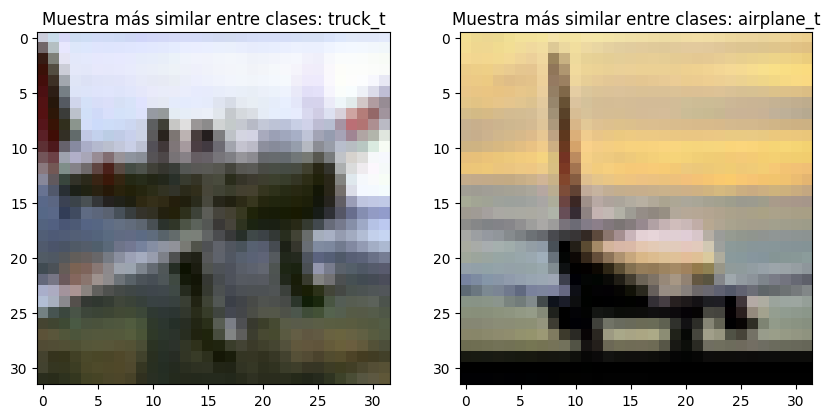

In [32]:
# Encuentra las muestras más similares entre clases (por ejemplo, entre "truck" y "truck_t")
most_similar_between_classes = [most_similar_in_i[0], most_similar_in_j[0]]


# Redimensiona las imágenes a un tamaño más pequeño (por ejemplo, 24x24x3)
small_images = [img.reshape(32, 32, 3) for img in most_similar_between_classes]

# Muestra las imágenes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(small_images[0])
axs[0].set_title(f'Muestra más similar entre clases: {class_names[i]}')
axs[1].imshow(small_images[1])
axs[1].set_title(f'Muestra más similar entre clases: {class_names[j]}')
plt.show()
